# Coronspec Tools example notebook

This notebook demonstrates how to use the coronspec tools library to work with HST-17092 data. It's a work-in-progress that will evolve as the coronspec library is built out.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt

In [4]:
from coronspec_tools import utils as ctutils

## List and organize the data files

I like to use a Pandas dataframe to organize my data files by metadata. Since all data files of the same type (e.g. sx1, sx2, flt, et cetera) have the same header keywords, they fit neatly into a dataframe format where the columns represent the keyword value and each row is a separate file. `coronspec_tools.utils` has some functions for setting this up.

In [5]:
# First, let's list all the data files available. Set your path as appropriate.
data_files = sorted(Path("../../data/MAST_2024-03-21T13_06_42.642Z/MAST_2024-03-21T13_06_42.642Z/HST/").glob("OF*/*fits"))

In [6]:
# here are all the files:
for i in data_files:
    print(i)

../../data/MAST_2024-03-21T13_06_42.642Z/MAST_2024-03-21T13_06_42.642Z/HST/OF0I01010/of0i01010_crj.fits
../../data/MAST_2024-03-21T13_06_42.642Z/MAST_2024-03-21T13_06_42.642Z/HST/OF0I01010/of0i01010_flt.fits
../../data/MAST_2024-03-21T13_06_42.642Z/MAST_2024-03-21T13_06_42.642Z/HST/OF0I01010/of0i01010_sx1.fits
../../data/MAST_2024-03-21T13_06_42.642Z/MAST_2024-03-21T13_06_42.642Z/HST/OF0I01010/of0i01010_sx2.fits
../../data/MAST_2024-03-21T13_06_42.642Z/MAST_2024-03-21T13_06_42.642Z/HST/OF0I01020/of0i01020_crj.fits
../../data/MAST_2024-03-21T13_06_42.642Z/MAST_2024-03-21T13_06_42.642Z/HST/OF0I01020/of0i01020_flt.fits
../../data/MAST_2024-03-21T13_06_42.642Z/MAST_2024-03-21T13_06_42.642Z/HST/OF0I01020/of0i01020_sx2.fits
../../data/MAST_2024-03-21T13_06_42.642Z/MAST_2024-03-21T13_06_42.642Z/HST/OF0I01030/of0i01030_crj.fits
../../data/MAST_2024-03-21T13_06_42.642Z/MAST_2024-03-21T13_06_42.642Z/HST/OF0I01030/of0i01030_flt.fits
../../data/MAST_2024-03-21T13_06_42.642Z/MAST_2024-03-21T13_06_4

In [7]:
# for each file type, let's make a separate "file manager" dataframe using utils.organize_files_by_header(list_of_files)
file_managers = {}
for f in data_files:
    ftype = f.stem.split("_")[1]
    if ftype not in file_managers.keys():
        file_managers[ftype] = []
    file_managers[ftype].append(f)
for ft in file_managers:
    file_managers[ft] = ctutils.organize_files_by_header(file_managers[ft])

In [8]:
print("The available filetypes are:", ', '.join(sorted(file_managers.keys())))

The available filetypes are: crj, flt, sx1, sx2


Here is what a dataframe looks like. The 'filepath' column is an absolute path to the file that can be used for IO (e.g. `fits.getdata(row['filepath'], 1)`).

In [9]:
file_managers['sx2'].head()

,db_id,SIMPLE,BITPIX,NAXIS,EXTEND,ORIGIN,DATE,NEXTEND,FILENAME,FILETYPE,...,MLINTAB,MOFFTAB,RIPTAB,SRWTAB,TDCTAB,TELTAB,SKYSUM,path,filestem,filepath
0,0,True,16,0,True,HSTIO/CFITSIO March 2010,2023-12-13,3,of0i01010_sx2.fits,SCI,...,N/A,N/A,N/A,N/A,N/A,N/A,0.0,../../data/MAST_2024-03-21T13_06_42.642Z/MAST_...,of0i01010,/Users/jaguilar/Projects/Research/hst17092-sti...
1,1,True,16,0,True,HSTIO/CFITSIO March 2010,2023-12-13,3,of0i01020_sx2.fits,SCI,...,N/A,N/A,N/A,N/A,N/A,N/A,0.0,../../data/MAST_2024-03-21T13_06_42.642Z/MAST_...,of0i01020,/Users/jaguilar/Projects/Research/hst17092-sti...
2,2,True,16,0,True,HSTIO/CFITSIO March 2010,2023-12-13,3,of0i01030_sx2.fits,SCI,...,N/A,N/A,N/A,N/A,N/A,N/A,0.0,../../data/MAST_2024-03-21T13_06_42.642Z/MAST_...,of0i01030,/Users/jaguilar/Projects/Research/hst17092-sti...
3,3,True,16,0,True,HSTIO/CFITSIO March 2010,2023-12-13,3,of0i02010_sx2.fits,SCI,...,N/A,N/A,N/A,N/A,N/A,N/A,0.0,../../data/MAST_2024-03-21T13_06_42.642Z/MAST_...,of0i02010,/Users/jaguilar/Projects/Research/hst17092-sti...
4,4,True,16,0,True,HSTIO/CFITSIO March 2010,2023-12-13,3,of0i02020_sx2.fits,SCI,...,N/A,N/A,N/A,N/A,N/A,N/A,0.0,../../data/MAST_2024-03-21T13_06_42.642Z/MAST_...,of0i02020,/Users/jaguilar/Projects/Research/hst17092-sti...


Compare with Becca's file information spreadsheet to see which ones go together: https://stsci.app.box.com/s/j3clm54y9c97iszpap4996e6nzwxvqzb/file/2050292260174. 

As a brief example into how I work with these dataframes: For example, let's say we want the unocculted and occulted exposures for HD 115692, the reference star for HD 114174. We can use the ROOTNAME keyword to uniqueluy identify them. In the spreadsheet, we find that that these correspond to `OF0I04010` and `OF0I04020`. We want the FLT files, in the `flt` file manager dataframe. Let's set the ROOTNAME to the index: 

In [10]:
file_managers['flt'].set_index("ROOTNAME").loc[['OF0I04010'.lower(), 'OF0I04020'.lower()]] # (these are stored in lowercase in the headers)

,db_id,SIMPLE,BITPIX,NAXIS,EXTEND,ORIGIN,DATE,NEXTEND,FILENAME,FILETYPE,...,IDCTAB,MLINTAB,MOFFTAB,RIPTAB,SRWTAB,TDCTAB,TELTAB,path,filestem,filepath
ROOTNAME,,,,,,,,,,,,,,,,,,,,,
of0i04010,11,True,16,0,True,HSTIO/CFITSIO March 2010,2024-03-20,6,of0i04010_flt.fits,SCI,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,../../data/MAST_2024-03-21T13_06_42.642Z/MAST_...,of0i04010,/Users/jaguilar/Projects/Research/hst17092-sti...
of0i04020,12,True,16,0,True,HSTIO/CFITSIO March 2010,2024-03-20,6,of0i04020_flt.fits,SCI,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,../../data/MAST_2024-03-21T13_06_42.642Z/MAST_...,of0i04020,/Users/jaguilar/Projects/Research/hst17092-sti...


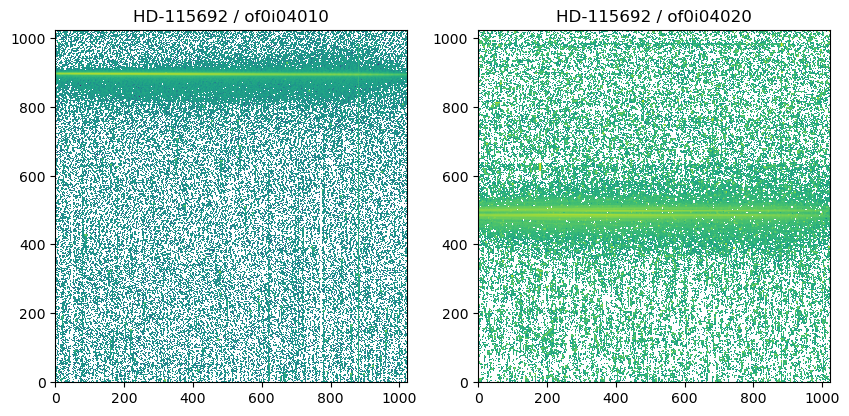

In [11]:
# We can plot them:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for i, (rootname, row) in enumerate(file_managers['flt'].set_index("ROOTNAME").loc[['OF0I04010'.lower(), 'OF0I04020'.lower()]].iterrows()):
    ax = axes.flat[i]
    ax.set_title(f"{row['TARGNAME']} / {rootname}")
    img = ctutils.fits.getdata(row['filepath'], 1)
    ax.imshow(img, norm=mpl.colors.LogNorm(), origin='lower')

## ObservingSequence Objects

`coronspec_tools` uses `ObservingSequence` objects to keep related files together. Specifically, some observing sequence includes a TA image, an unocculted exposure, and an occulted exposure. The hstcal pipeline also generates a 1-D spectrum from the unocculted trace that is useful in processing the exposures. ObservingSequence objects use these files to derive the row position of the star in the occulted exposures and prepare the PSF subtraction. Let's see how they work:


In [12]:
from coronspec_tools import observing_sequence
# let's see the docstring
observing_sequence.ObsSeq?

Init signature:
observing_sequence.ObsSeq(
    sx1_file: str | pathlib.Path,
    unocc_file: str | pathlib.Path,
    occ_file: str | pathlib.Path,
) -> None
Docstring:      <no docstring>
Init docstring:
Instantiate a class to manage injection of spectral traces into 2-D
spectral images. This includes rescaling and reshaping the spectra.

Parameters
----------
sx1_file : str | Path
  file containing the wavelength solution and extracted spectrum
unocc_file : str | Path
  file containing the 2-D unocculted spectral image
occ_file : str | Path
  file containing the 2-D occulted spectral image

Output
------
None
File:           ~/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py
Type:           type
Subclasses:     

In [13]:
# we need the sx1 file, the unocculted exposure, and the occulted exposure. Looking at the Data Spreadsheet, these are:
sx1_rootname = 'OF0I04010'.lower()
unocc_rootname = 'OF0I04010'.lower()
occ_rootname = 'OF0I04020'.lower()

# the sx1 file is in the sx1 file manager:
sx1_file = file_managers['sx1'].set_index("ROOTNAME").loc[sx1_rootname]['filepath']
# we're going to use the _un_rectified 2-D spectral images
unocc_file = file_managers['flt'].set_index("ROOTNAME").loc[unocc_rootname]['filepath']
occ_file = file_managers['flt'].set_index("ROOTNAME").loc[occ_rootname]['filepath']

In [18]:
ref_obs = observing_sequence.ObsSeq(
    sx1_file=sx1_file,
    unocc_file=unocc_file,
    occ_file=occ_file
)

  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]


The `ref_obs` object has the following attributes:
- `_files` : a dict that keeps a record of the initializing files
- `wlsol`: the wavelength solution, in meters
- `primary_spectrum`: the point source spectrum, in units of counts/sec
- `primary_spectrum_unc`: the associated uncertainty from the `ERR` column
- `unocc_wcs`: WCS object for the unocculted observation
- `unocc_img`: 2-D spectral image of the unocculted
- `offset`: distance in degrees of the unocculted point source from the nominal position
- `unocc_row`: 0-indexed row coordinate corresponding to the offset in the unocculted exposure
- `unocc_trace`: astropy.nddata.Cutout2D crop of the spectral trace; used for injection and recovery tests
- `occ_wcs`: WCS object for the occulted observation
- `occ_img`: 2-D spectral image of the occulted observation
- `occ_row`: 0-indexed row coordinate corresponding to the offset in the occulted exposure, aka where the star is

We can overplot the nominal, measured, and inferred positions on the images:

In [30]:
from astropy import units

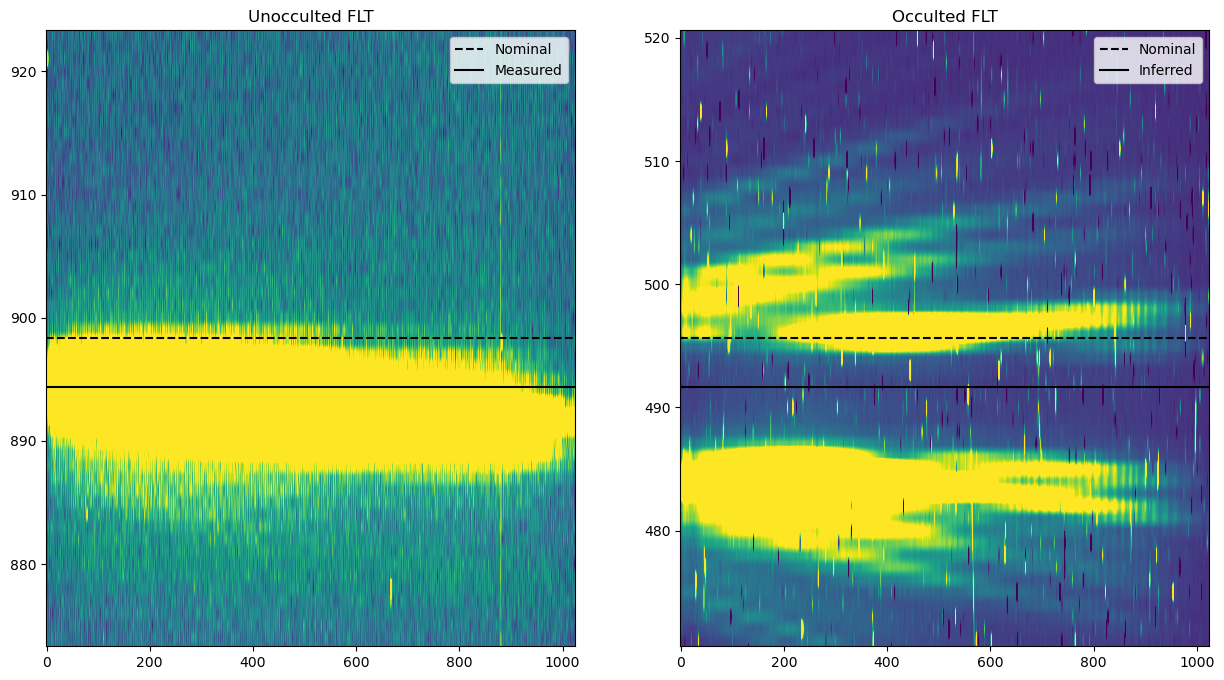

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
# fig.suptitle(hdr['TARGNAME'] + '\n' + hdr['ROOTNAME'] + '\n' + f"POSTARG2: {hdr['POSTARG2']}")
ax = axes[0]
ax.set_title("Unocculted FLT")
vmin, vmax = np.nanquantile(ref_obs.unocc_img, [0.01, 0.99])
ax.imshow(
    ref_obs.unocc_img, vmin=vmin, vmax=vmax, origin='lower'
)
nominal_col, nominal_row = ref_obs.unocc_wcs.world_to_pixel_values(
    ref_obs.wlsol.min(), 
    units.Quantity(0, unit='deg')
)
ax.axhline(nominal_row, c='k', ls='--', label='Nominal')
ax.axhline(ref_obs.unocc_row, c='k', ls='-', label='Measured')
ax.legend()
ax.set_ylim(nominal_row-25, nominal_row+25)
ax.set_aspect("auto")

ax = axes[1]
ax.set_title("Occulted FLT")
vmin, vmax = np.nanquantile(ref_obs.occ_img, [0.01, 0.99])
ax.imshow(
    ref_obs.occ_img, vmin=vmin, vmax=vmax, origin='lower'
)
nominal_col, nominal_row = ref_obs.occ_wcs.world_to_pixel_values(
    ref_obs.wlsol.min(), 
    units.Quantity(0, unit='deg')
)
ax.axhline(nominal_row, c='k', ls='--', label='Nominal')
ax.axhline(ref_obs.occ_row, c='k', ls='-', label='Inferred')
ax.legend()
ax.set_ylim(nominal_row-25, nominal_row+25)
ax.set_aspect("auto")

Now that we have all the reference star data in one place, we can do the same for the science observations. These have rootnames with the `OF0I03` instead of `OF0I04`:

In [37]:
# we need the sx1 file, the unocculted exposure, and the occulted exposure. Looking at the Data Spreadsheet, these are:
sx1_rootname = 'OF0I03010'.lower()
unocc_rootname = 'OF0I03010'.lower()
occ_rootname = 'OF0I03020'.lower()

# the sx1 file is in the sx1 file manager:
sx1_file = file_managers['sx1'].set_index("ROOTNAME").loc[sx1_rootname]['filepath']
# we're going to use the _un_rectified 2-D spectral images
unocc_file = file_managers['flt'].set_index("ROOTNAME").loc[unocc_rootname]['filepath']
occ_file = file_managers['flt'].set_index("ROOTNAME").loc[occ_rootname]['filepath']

sci_obs = observing_sequence.ObsSeq(
    sx1_file=sx1_file,
    unocc_file=unocc_file,
    occ_file=occ_file
)

  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]


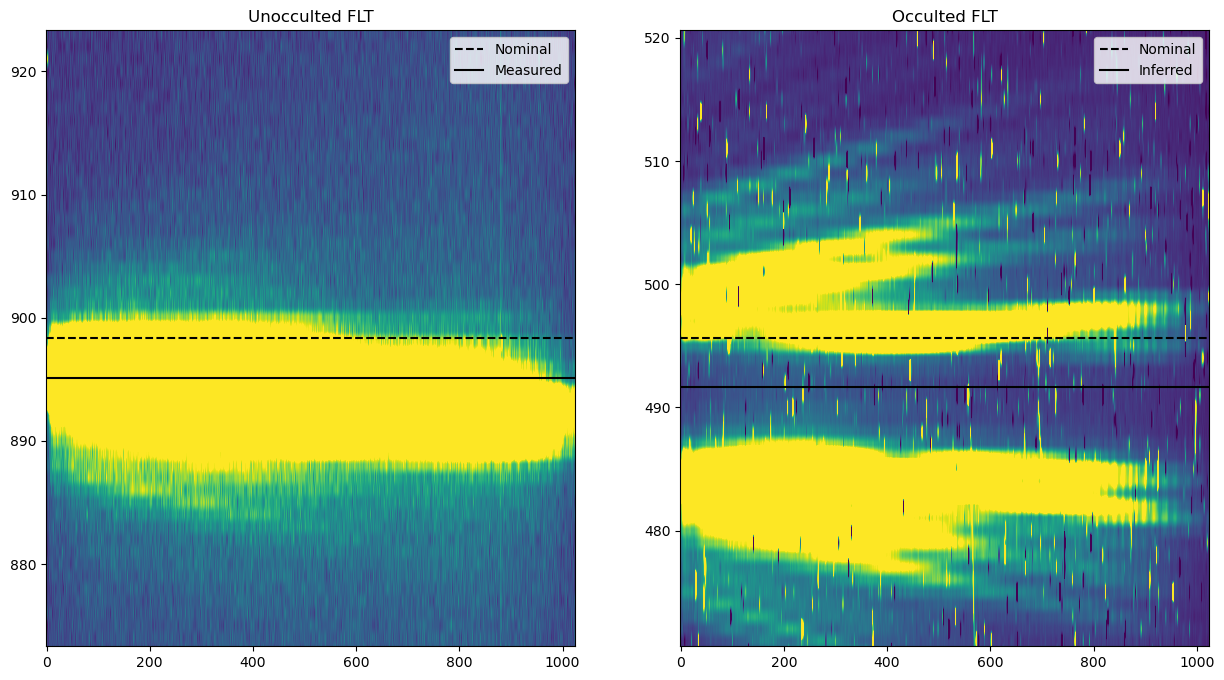

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
# fig.suptitle(hdr['TARGNAME'] + '\n' + hdr['ROOTNAME'] + '\n' + f"POSTARG2: {hdr['POSTARG2']}")
ax = axes[0]
ax.set_title("Unocculted FLT")
vmin, vmax = np.nanquantile(sci_obs.unocc_img, [0.01, 0.99])
ax.imshow(
    sci_obs.unocc_img, vmin=vmin, vmax=vmax, origin='lower'
)
nominal_col, nominal_row = sci_obs.unocc_wcs.world_to_pixel_values(
    sci_obs.wlsol.min(), 
    units.Quantity(0, unit='deg')
)
ax.axhline(nominal_row, c='k', ls='--', label='Nominal')
ax.axhline(sci_obs.unocc_row, c='k', ls='-', label='Measured')
ax.legend()
ax.set_ylim(nominal_row-25, nominal_row+25)
ax.set_aspect("auto")

ax = axes[1]
ax.set_title("Occulted FLT")
vmin, vmax = np.nanquantile(sci_obs.occ_img, [0.01, 0.99])
ax.imshow(
    ref_obs.occ_img, vmin=vmin, vmax=vmax, origin='lower'
)
nominal_col, nominal_row = sci_obs.occ_wcs.world_to_pixel_values(
    sci_obs.wlsol.min(), 
    units.Quantity(0, unit='deg')
)
ax.axhline(nominal_row, c='k', ls='--', label='Nominal')
ax.axhline(ref_obs.occ_row, c='k', ls='-', label='Inferred')
ax.legend()
ax.set_ylim(nominal_row-25, nominal_row+25)
ax.set_aspect("auto")